# Salinity using mfopen

In [1]:
import dask.distributed as dsk
import glob
import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [3]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41979/status,
Dashboard: /proxy/41979/status,Workers: 28
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33169,Workers: 28
Dashboard: /proxy/41979/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:45839,Total threads: 1
Dashboard: /proxy/40557/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45523,


In [4]:
pathsC = np.sort(glob.glob('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))[-66:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [5]:
shelf_mask = shelf_mask = xr.open_dataset('/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc')['contour_masked_above']

In [6]:
areaC = xr.open_dataset('/g/data/ik11/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])
areaM = xr.open_dataset('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/output020/20010101.ocean_static.nc')['areacello'].sel(xh=shelf_mask['xh'])

In [7]:
def preprocess(ds):
    ds = ds[['so', 'volcello']].sel(yh=shelf_mask['yh'], z_l=slice(400,1000))
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [8]:
saltC = cont['so']
volcC = cont['volcello']
thikC = cont['volcello']/areaC

In [9]:
saltM = melt['so']
volcM = melt['volcello']
thikM = melt['volcello']/areaM

In [10]:
salt_bot_C = saltC.weighted(thikC.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaC.fillna(0)).mean(['xh', 'yh'])
salt_bot_M = saltM.weighted(thikM.fillna(0)).mean('z_l').where(shelf_mask == 0).weighted(areaM.fillna(0)).mean(['xh', 'yh'])

In [11]:
salt_bot_C = salt_bot_C.load()

In [12]:
salt_bot_M = salt_bot_M.load()

In [13]:
# Saving
salt_bot_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltC_botshelf_time.nc')
salt_bot_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltM_botshelf_time.nc')

Text(0.5, 1.0, 'Panan01 Time Series of Salinity for shelf below 400m')

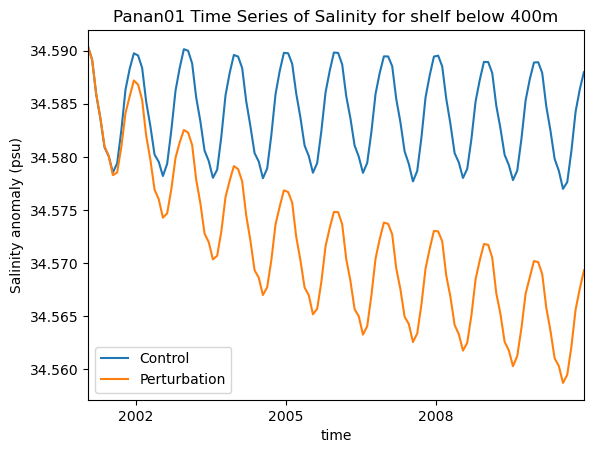

In [14]:
salt_bot_C.plot(label="Control")
salt_bot_M.plot(label="Perturbation")
plt.xlim(380,4000)
#plt.ylim(-1.30,-0.70)
plt.ylabel("Salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("Panan01 Time Series of Salinity for shelf below 400m")

## Comparing resolutions

In [15]:
saltpert_005 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltM_botshelf_time.nc', chunks = 'auto')
saltcont_005 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan005_saltC_botshelf_time.nc', chunks = 'auto')
saltpert_01 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltM_botshelf_time.nc', chunks = 'auto')
saltcont_01 = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/pan01_saltC_botshelf_time.nc', chunks = 'auto')

In [18]:
saltanom_005 = saltpert_005 - saltcont_005
saltanom_005 = saltanom_005.load()

In [19]:
saltanom_01 = saltpert_01 - saltcont_01
saltanom_01 = saltanom_01.load()

Text(0.5, 1.0, 'Time Series of salinity anomaly for shelf below 400m')

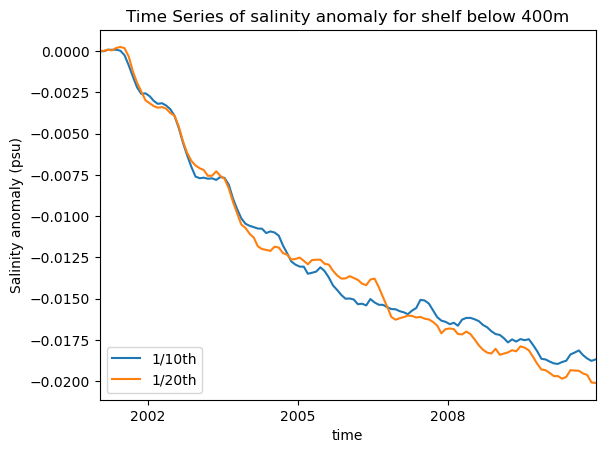

In [23]:
saltanom_01.plot(label="1/10th")
saltanom_005.plot(label="1/20th")
plt.xlim(380,4000)
#plt.ylim(-0.015,0.03)
plt.ylabel("Salinity anomaly (psu)")
plt.legend(loc="lower left")
plt.title("Time Series of salinity anomaly for shelf below 400m")